##Import Libraries 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from google.colab.patches import cv2_imshow
import math

##Mount Google Drive

In [ ]:
from google.colab import drive
# drive.mount('drive')
drive.mount("drive", force_remount=True)

Mounted at drive


### Loading First Frame of Video

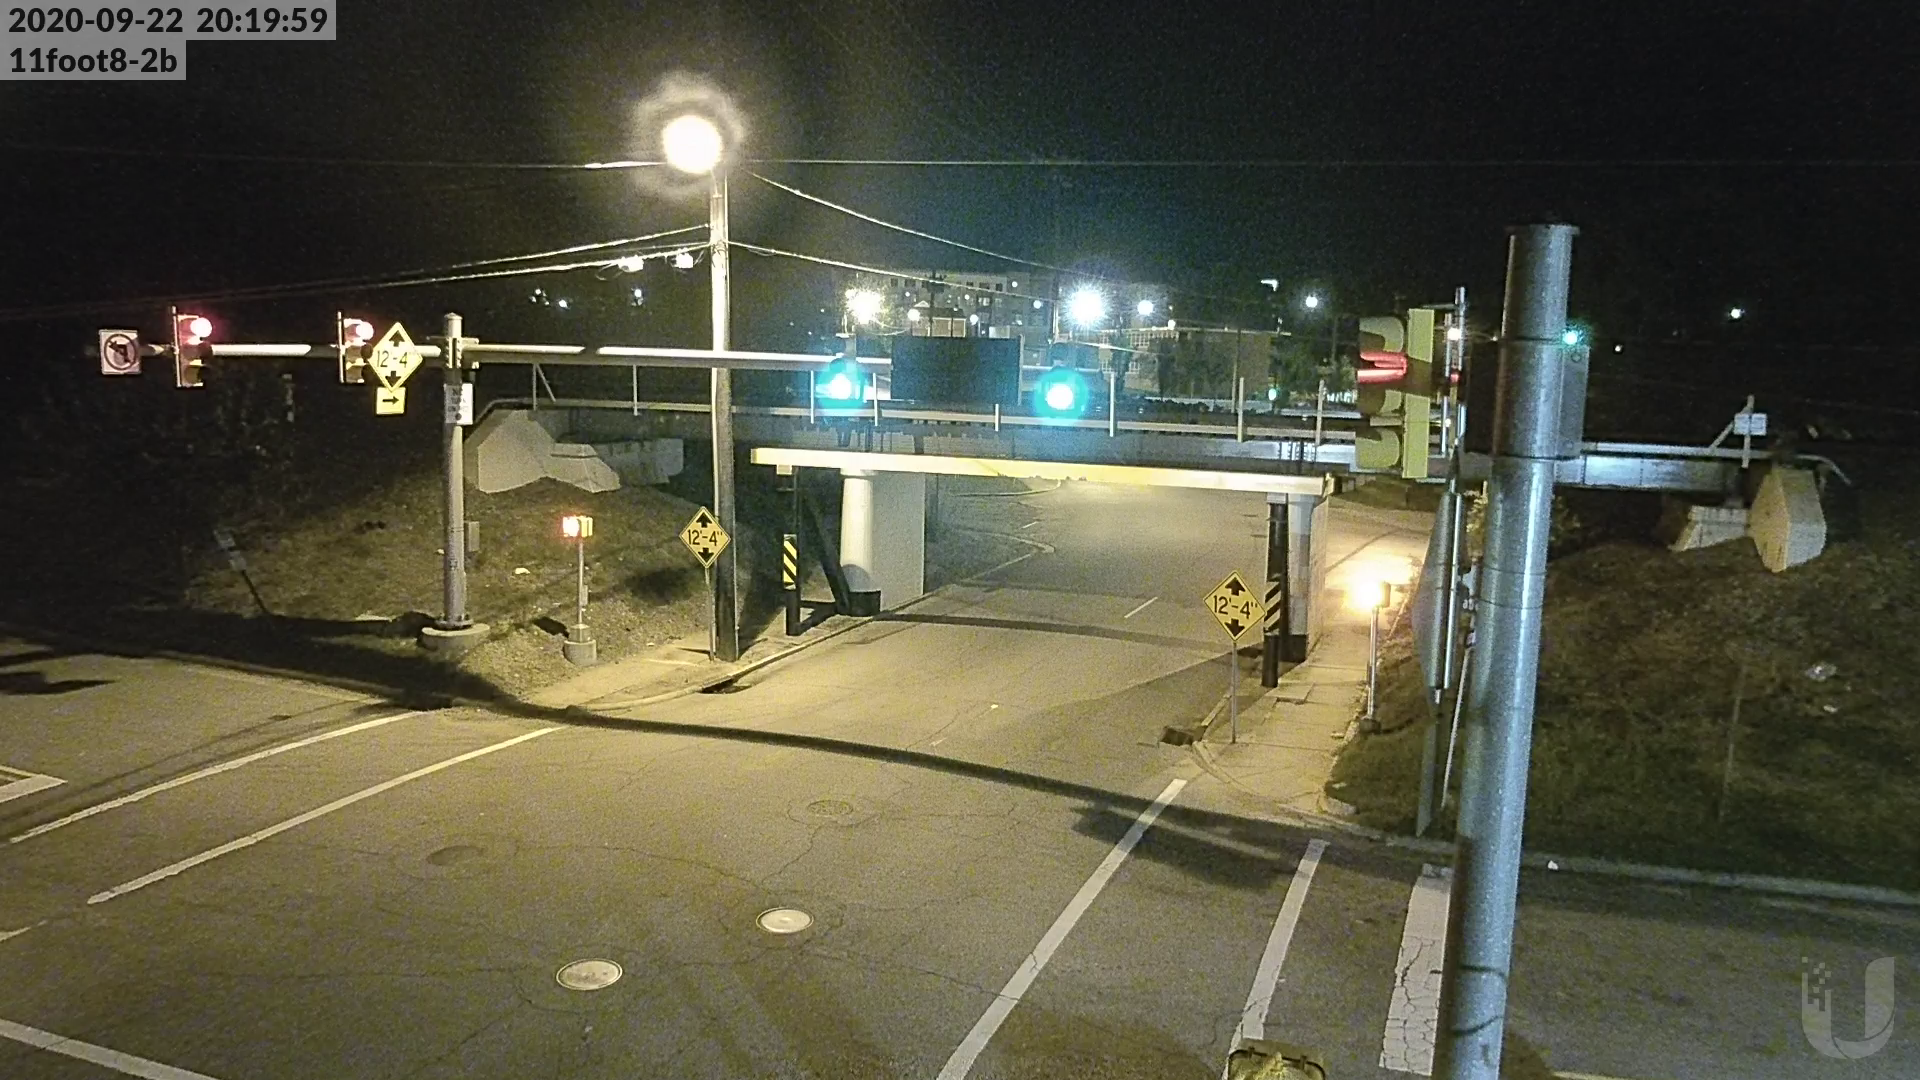

In [ ]:
def getFirstFrame(videofile):
    vidcap = cv2.VideoCapture(videofile)
    success, image = vidcap.read()
    return image

# Reference Frame (Histogram Matching)
# cap_ref = '/content/drive/MyDrive/ECE_588/2020-09-22_RV-fast-night-crash-c158.mp4' # Night-time test case
cap_ref = '/content/drive/MyDrive/ECE_588/2022-06-14_Penske-left-turn-c176.mp4' # Daytime test case

# Target Frame (Histogram Matching)
# cap = '/content/drive/MyDrive/ECE_588/2019-12-19_Lost-cargo-evening-light-c152.mp4' # Evening test case
# cap = '/content/drive/MyDrive/ECE_588/2021-07-14_enterprise-keeps-going-c170.mp4' # Medium Overlap
# cap = '/content/drive/MyDrive/ECE_588/2021-10-21_semi-c173.mp4' # Small overlap
# cap = '/content/drive/MyDrive/ECE_588/2022-06-14_Penske-left-turn-c176.mp4' # Daytime test case
# cap = '/content/drive/MyDrive/ECE_588/2020-11-13_stuck-fairing_c160.mp4' # Cloudy test case
# cap = '/content/drive/MyDrive/ECE_588/2021-10-14_roof-peeled-c172.mp4' # Shadow-effect
cap = '/content/drive/MyDrive/ECE_588/2020-09-22_RV-fast-night-crash-c158.mp4' # Night-time test case

image = getFirstFrame(cap)
from skimage import exposure
from skimage.exposure import match_histograms
ref = getFirstFrame(cap_ref)
shadow = False
if shadow == True:
  image = match_histograms(image, ref, multichannel=True)
cv2_imshow(image)

### Edge Detection on First Frame (Obtain Cropping Parameters)

grayscale threshold:  19.483999999999998


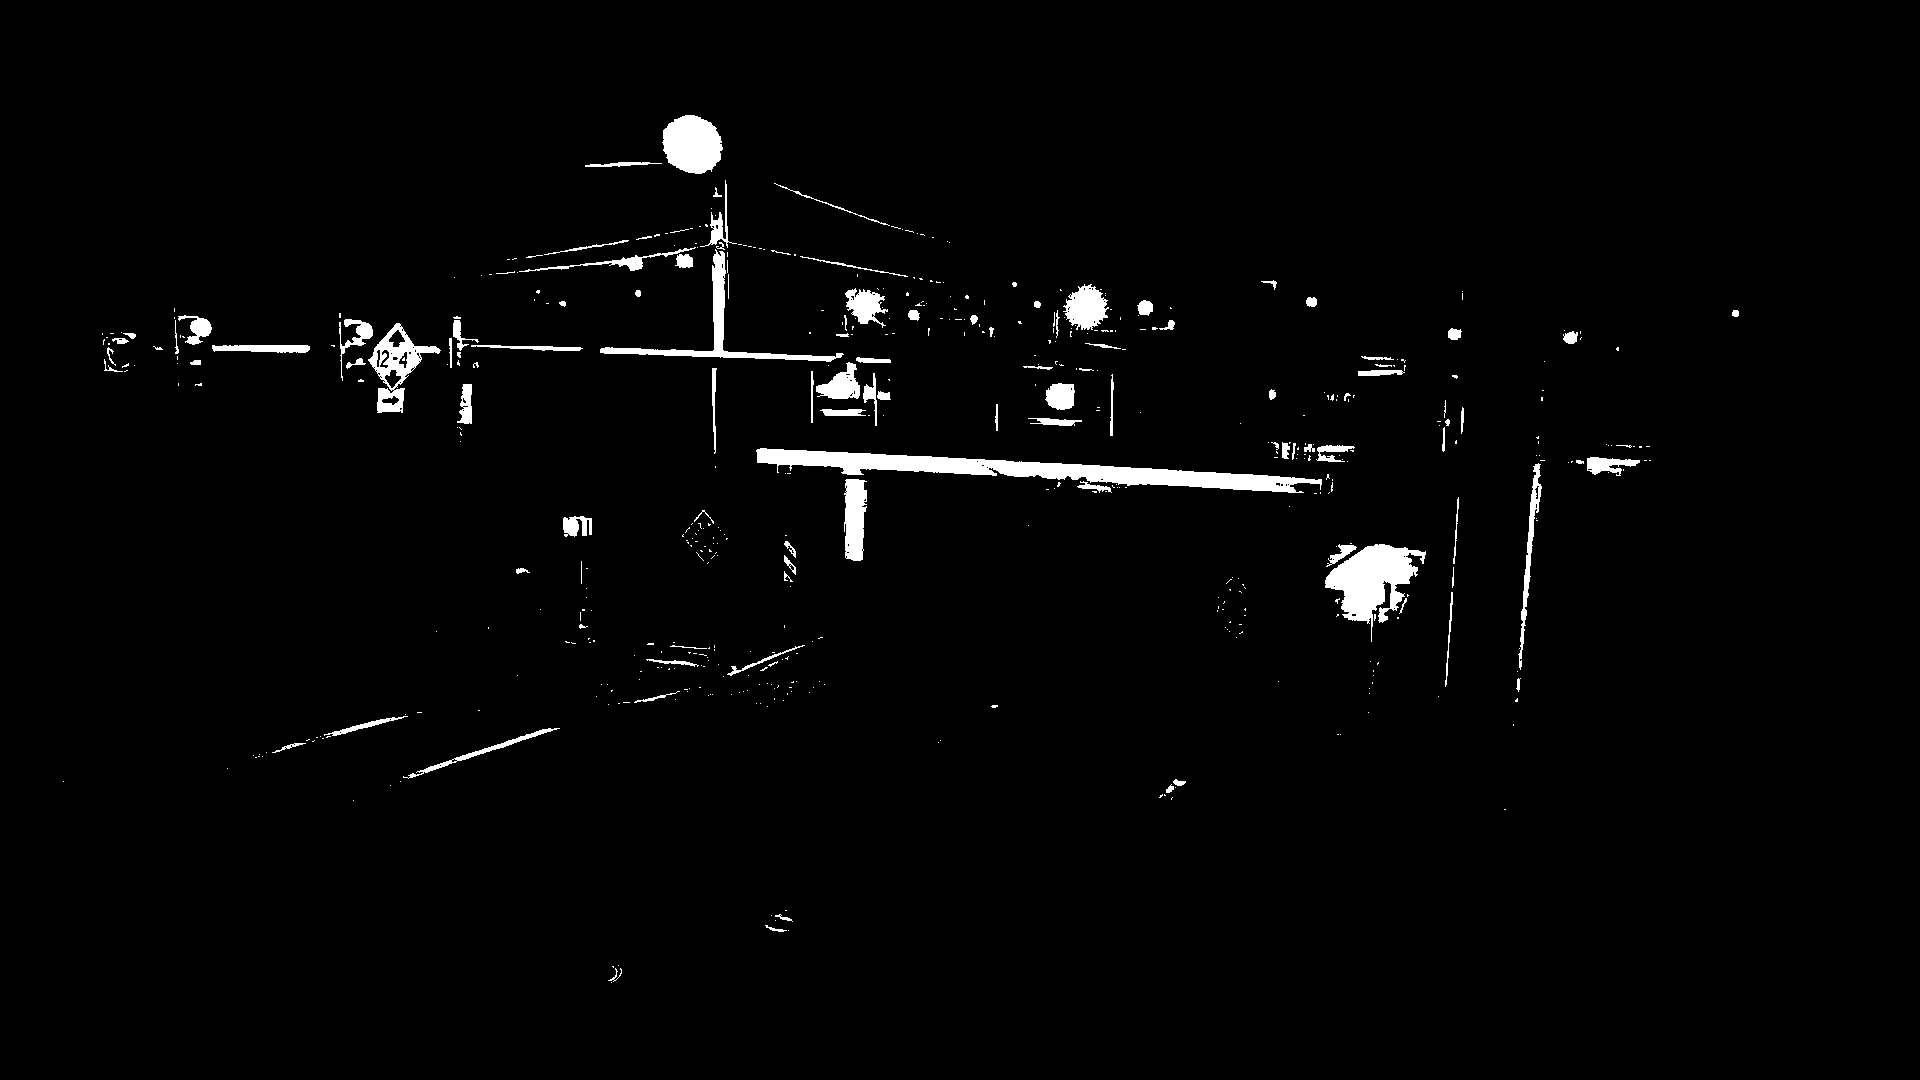

In [ ]:
def colorDetection(image, lower, upper):
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    color_mask = cv2.inRange(hsv, lower, upper)
    output = cv2.bitwise_and(image, image, mask=color_mask)
    output[color_mask>0]=(255,255,255)

    return output

threshold_gray = np.dot(image[0,-1,:], [0.299, 0.587, 0.114])
print("grayscale threshold: ",threshold_gray)
white_lower = np.array([0, 0, 235]);    white_upper = np.array([255, 100, 255]) #235
orange_lower = np.array([10, 100, 200]); orange_upper = np.array([27, 255, 255]) #90

if threshold_gray < 100:
  new_image = colorDetection(image, white_lower, white_upper)
else:
  new_image = colorDetection(image, orange_lower, orange_upper)

cv2_imshow(new_image)

Number of contours in image: 630
[[754, 470], [756, 447], [1321, 474], [1320, 498]]


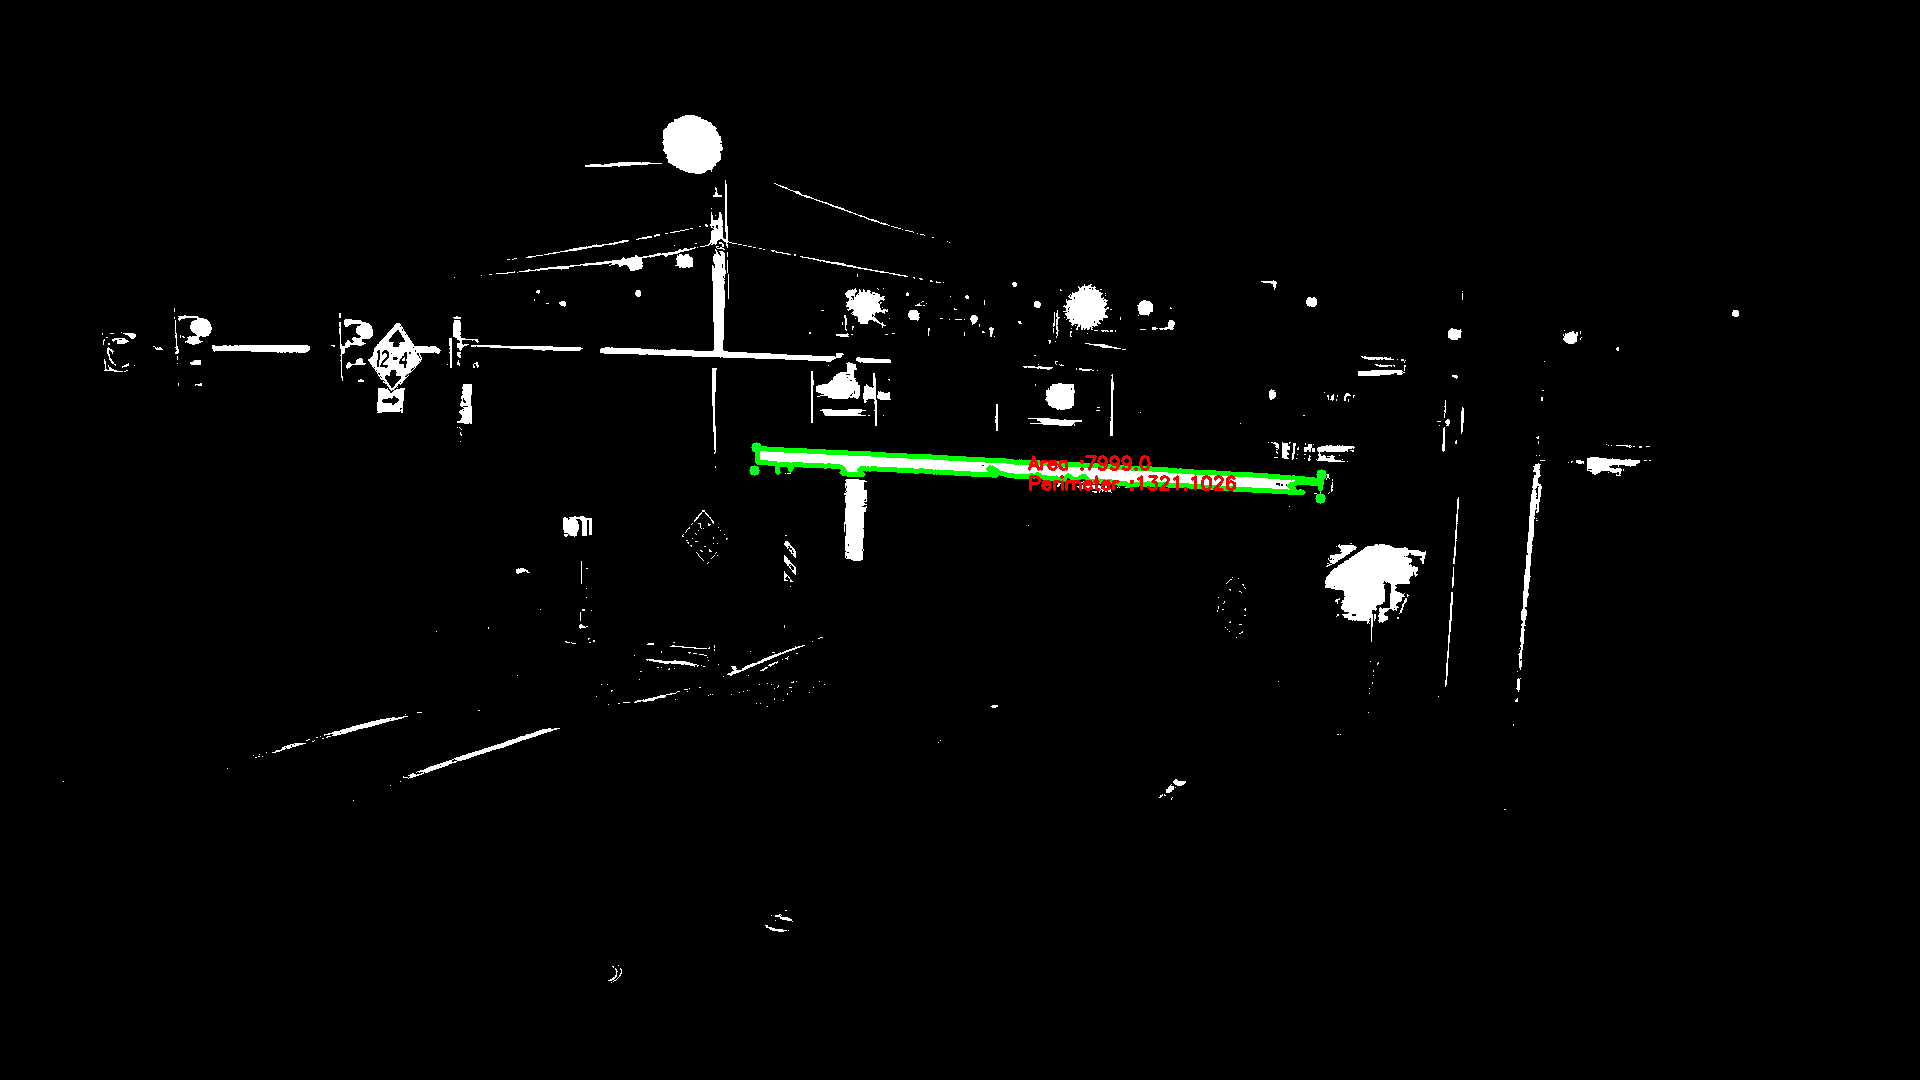

In [ ]:
img1 = new_image.copy()
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(img1,10,255,0)
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print("Number of contours in image:",len(contours))

max_perimeter = 0; max_area = 0; max_cnt = None;
for i, cont in enumerate(contours):
   area = cv2.contourArea(cont)
   perimeter = cv2.arcLength(cont, True)
   perimeter = round(perimeter, 4)
   if perimeter > max_perimeter:
     max_perimeter = perimeter
     max_area = area
     max_cnt = cont

M = cv2.moments(max_cnt)
if M['m00'] != 0.0:
  x1 = int(M['m10']/M['m00'])
  y1 = int(M['m01']/M['m00'])

img2 = new_image.copy()
img2 = cv2.drawContours(img2, [max_cnt], -1, (0,255,0), 3,)
cv2.putText(img2, f'Area :{max_area}', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
cv2.putText(img2, f'Perimeter :{max_perimeter}', (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# Find distorted bounding rect
mask = np.zeros(img2.shape[:2], dtype=np.uint8)
rect = cv2.minAreaRect(max_cnt)
corners = cv2.boxPoints(rect)
corners = np.int0(corners)
cv2.fillPoly(mask, [corners], (255,255,255))

# Draw corner points
corners = corners.tolist()
print(corners)
for corner in corners:
    x, y = corner
    cv2.circle(img2, (x, y), 5, (36,255,12), -1)

cv2_imshow(img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Dynamically Cropping Crash Data

In [ ]:
def get_euler_distance(pt1, pt2):
    return ((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)**0.5

src_pts = np.array(corners, dtype=np.float32)
width = get_euler_distance(src_pts[0], src_pts[1])
height = get_euler_distance(src_pts[0], src_pts[3])

dst_pts = np.array([[0, 0],   [width, 0],  [width, height], [0, height]], dtype=np.float32)

M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp = cv2.warpPerspective(image, M, (int(width), int(height)))
yellow_lower = np.array([22, 75, 0]); yellow_upper = np.array([45, 255, 255])

if threshold_gray < 100:
  new_warp_1 = colorDetection(warp, white_lower, white_upper)
  new_warp_2 = colorDetection(warp, yellow_lower, yellow_upper)
  new_warp = new_warp_1 + new_warp_2
else:
  new_warp = colorDetection(warp, orange_lower, orange_upper)

img = cv2.cvtColor(new_warp, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(img,10,255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2)
# print("Number of contours in image:",len(contours))

max_perimeter = 0; max_area = 0; max_cnt = None;
for i, cont in enumerate(contours):
  area = cv2.contourArea(cont)
  perimeter = cv2.arcLength(cont, True)
  perimeter = round(perimeter, 4)
  if perimeter > max_perimeter:
    max_perimeter = perimeter
    max_area = area
    max_cnt = cont

Mom = cv2.moments(max_cnt)
if Mom['m00'] != 0.0:
  x1 = int(Mom['m10']/Mom['m00'])
  y1 = int(Mom['m01']/Mom['m00'])

img2 = warp.copy()
img2 = cv2.drawContours(img2, [max_cnt], -1, (0,255,0), 3,)
print('Area of Warped Clearance Bar in First Frame:',max_area); 
print('Perimeter of Warped Clearance Bar in First Frame:',max_perimeter);
cv2_imshow(cv2.rotate(img2,cv2.ROTATE_90_COUNTERCLOCKWISE))

Area of Warped Clearance Bar in First Frame: 8550.0
Perimeter of Warped Clearance Bar in First Frame: 1511.6711


### Detecting Crashes

In [ ]:
import numpy as np
import cv2

# Open the video
video = cv2.VideoCapture(cap)

# Initialize frame counter
cnt = 0

# Some characteristics from the original video
fps, frames = video.get(cv2.CAP_PROP_FPS), video.get(cv2.CAP_PROP_FRAME_COUNT)
wb = cv2.xphoto.createGrayworldWB()
wb.setSaturationThreshold(0.99)

# Now we start
while(video.isOpened()):
    ret, frame = video.read()
    cnt += 1 # Counting frames

    # Percentage
    xx = cnt *100/frames
    # if int(xx) < 12:
    #   continue
    print(int(xx),'%')

    if shadow == True:
      frame = match_histograms(frame, ref, multichannel=True)

    # Avoid problems when video finish
    if ret==True:
        # Cropping the frame
        crop_frame = cv2.warpPerspective(frame, M, (int(width), int(height)))
        crop_frame = match_histograms(crop_frame, warp, multichannel=True)
        # cv2_imshow(cv2.rotate(crop_frame,cv2.ROTATE_90_COUNTERCLOCKWISE))

        if threshold_gray < 100:
          new_frame_1 = colorDetection(crop_frame, white_lower, white_upper)
          new_frame_2 = colorDetection(crop_frame, yellow_lower, yellow_upper)
          new_frame = new_frame_1 + new_frame_2
        else:
          new_frame = colorDetection(crop_frame, orange_lower, orange_upper)

        img = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(img,10,255,0)
        contours,hierarchy = cv2.findContours(thresh, 1, 2)
        # print("Number of contours in image:",len(contours))

        new_perimeter = 0; new_area = 0; new_cnt = None;
        for i, cont in enumerate(contours):
          area = cv2.contourArea(cont)
          perimeter = cv2.arcLength(cont, True)
          perimeter = round(perimeter, 4)
          if perimeter > new_perimeter:
            new_perimeter = perimeter
            new_area = area
            new_cnt = cont

        print('Area of Warped Clearance Bar in Current Frame:',new_area); 
        print('Perimeter of Warped Clearance Bar in Current Frame:',new_perimeter);
        if np.abs(max_area - new_area) > (0.04308*max_area - 10.92):
            Mom = cv2.moments(new_cnt)
            if Mom['m00'] != 0.0:
              x1 = int(Mom['m10']/Mom['m00'])
              y1 = int(Mom['m01']/Mom['m00'])

            new_frame = cv2.drawContours(new_frame, [new_cnt], -1, (0,255,0), 3,)
            cv2_imshow(cv2.rotate(new_frame,cv2.ROTATE_90_COUNTERCLOCKWISE))

            # Converting fractional time to Min:Sec
            time = (cnt/frames)*(10/60)
            minutes = (time*60) % 60
            seconds = (time*3600) % 60
            print("Crash detected at %02d minutes %02d seconds" % (minutes, seconds))
            break

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break


video.release()
cv2.destroyAllWindows()

0 %
Area of Warped Clearance Bar in Current Frame: 8550.0
Perimeter of Warped Clearance Bar in Current Frame: 1511.6711
0 %
Area of Warped Clearance Bar in Current Frame: 8573.0
Perimeter of Warped Clearance Bar in Current Frame: 1503.6711
0 %
Area of Warped Clearance Bar in Current Frame: 8569.5
Perimeter of Warped Clearance Bar in Current Frame: 1579.0853
0 %
Area of Warped Clearance Bar in Current Frame: 8475.0
Perimeter of Warped Clearance Bar in Current Frame: 1574.9848
0 %
Area of Warped Clearance Bar in Current Frame: 8516.0
Perimeter of Warped Clearance Bar in Current Frame: 1510.7006
0 %
Area of Warped Clearance Bar in Current Frame: 8419.5
Perimeter of Warped Clearance Bar in Current Frame: 1595.9138
0 %
Area of Warped Clearance Bar in Current Frame: 8364.5
Perimeter of Warped Clearance Bar in Current Frame: 1437.9727
0 %
Area of Warped Clearance Bar in Current Frame: 8424.0
Perimeter of Warped Clearance Bar in Current Frame: 1515.328
0 %
Area of Warped Clearance Bar in Curre

Crash detected at 00 minutes 17 seconds


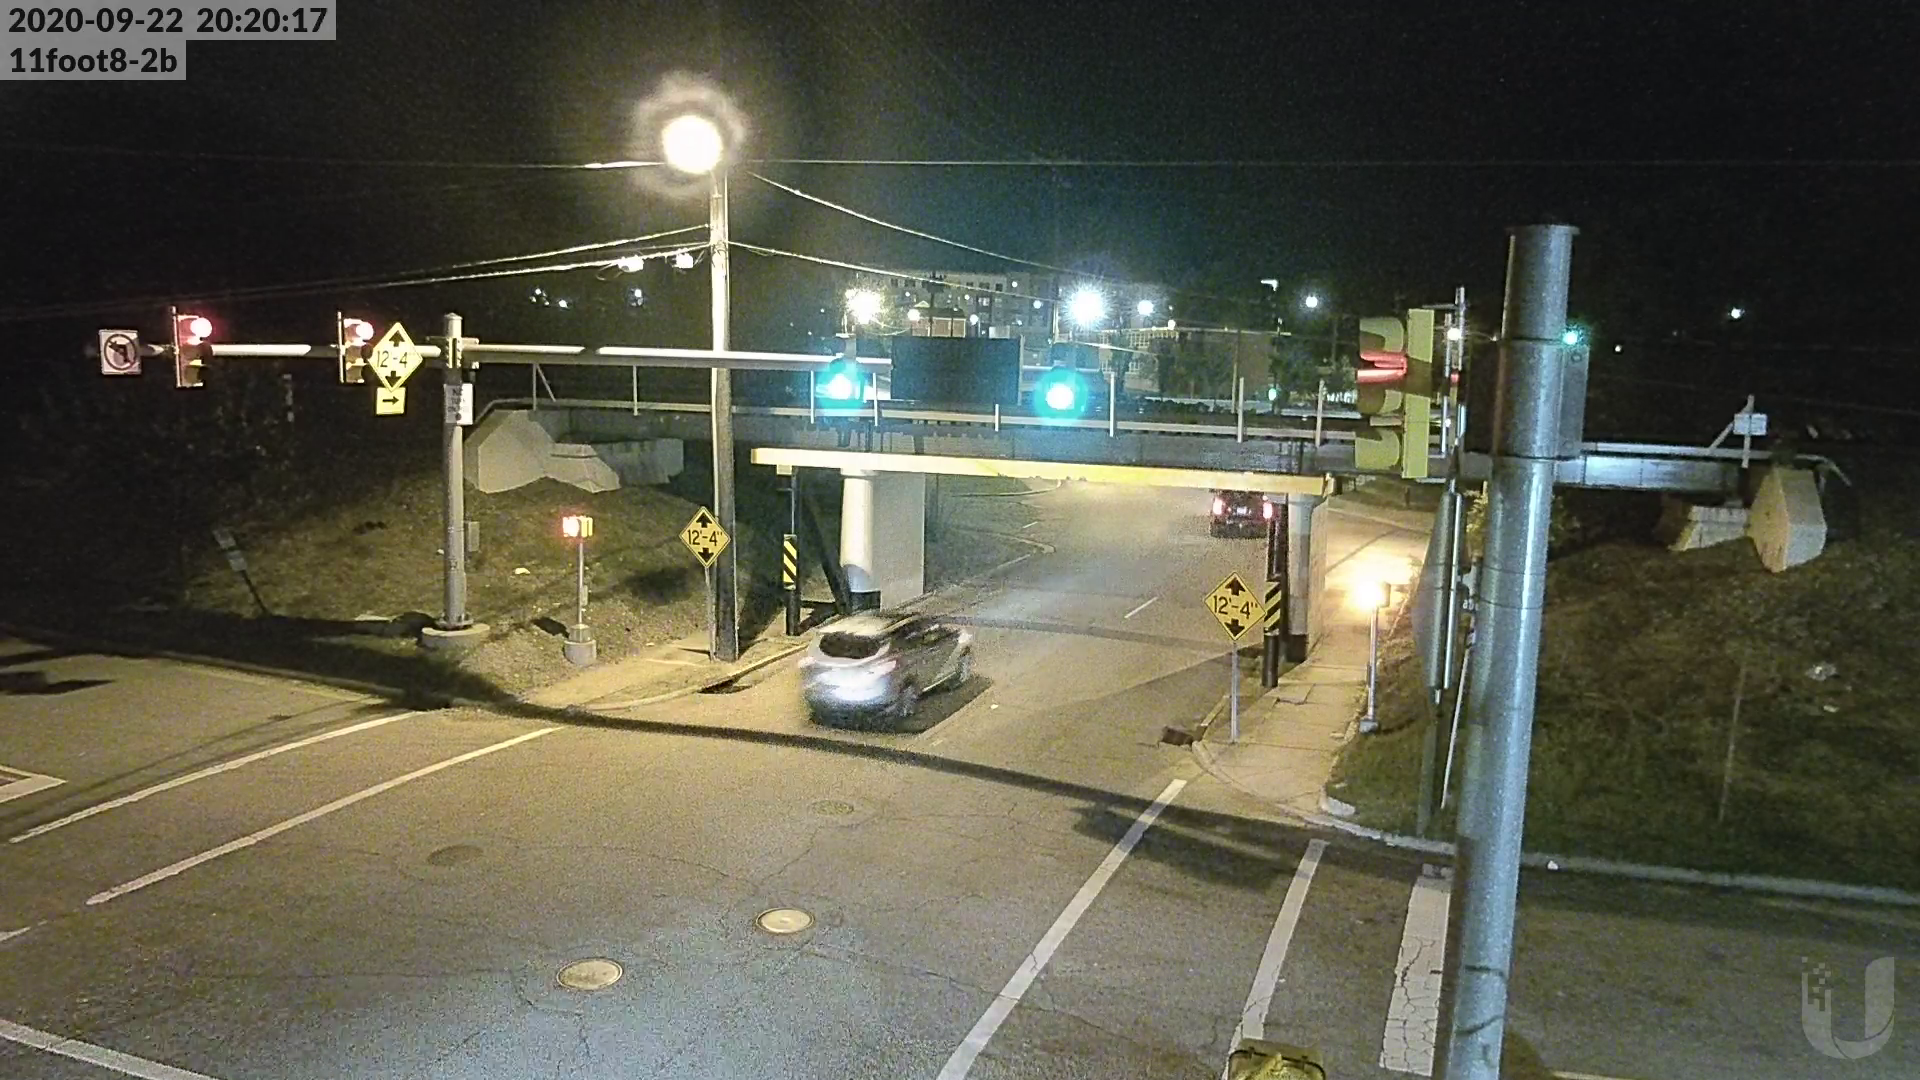

In [ ]:
cv2_imshow(frame)

In [ ]:
cv2_imshow(cv2.rotate(crop_frame,cv2.ROTATE_90_COUNTERCLOCKWISE))

if threshold_gray < 100:
  new_frame_1 = colorDetection(crop_frame, white_lower, white_upper)
  new_frame_2 = colorDetection(crop_frame, yellow_lower, yellow_upper)
  new_frame = new_frame_1 + new_frame_2
else:
  new_frame = colorDetection(crop_frame, orange_lower, orange_upper)

img = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(img,10,255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2)
print("Number of contours in image:",len(contours))

new_perimeter = 0; new_area = 0; new_cnt = None;
for i, cont in enumerate(contours):
  area = cv2.contourArea(cont)
  perimeter = cv2.arcLength(cont, True)
  perimeter = round(perimeter, 4)
  if perimeter > new_perimeter:
    new_perimeter = perimeter
    new_area = area
    new_cnt = cont

print(new_area); print(new_perimeter);
Mom = cv2.moments(new_cnt)
if Mom['m00'] != 0.0:
  x1 = int(Mom['m10']/Mom['m00'])
  y1 = int(Mom['m01']/Mom['m00'])

new_frame = cv2.drawContours(crop_frame, [new_cnt], -1, (0,255,0), 3,)
cv2_imshow(cv2.rotate(crop_frame,cv2.ROTATE_90_COUNTERCLOCKWISE))

Number of contours in image: 41
8159.0
1385.529
